In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

C:\Anaconda\envs\mv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [41]:
df_train = pd.read_csv('../../csv/train_modifie.csv')
df_test = pd.read_csv('../../csv/test_modifie.csv')

df_train = df_train.drop(['day_length'], axis=1)
df_test = df_test.drop(['day_length'], axis=1)

In [42]:
X_train = df_train.drop(['registered', 'casual'], axis=1)
y_train_registered = df_train['registered']
y_train_casual = df_train['casual']

X_test = df_test.drop(['registered', 'casual'], axis=1)
y_test_registered = df_test['registered']
y_test_casual = df_test['casual']

In [43]:
# On supprime toutes les colonnes catégorielles
weather = X_train['weather']
X_train_seg = X_train.drop(['season', 'holiday', 'workingday', 'weather', 'day_light', 'months', 'years', 'hours', 'week_days'], axis=1)

In [44]:
# On supprime toutes les colonnes catégorielles
X_test_seg = X_test.drop(['season', 'holiday', 'workingday', 'weather', 'day_light', 'months', 'years', 'hours', 'week_days'], axis=1)

## KMeans

In [10]:
scaler = StandardScaler()

In [11]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
pipeline_kmeans = make_pipeline(scaler, kmeans)

pipeline_kmeans.fit(X_train_seg)
clusters = pipeline_kmeans.predict(X_train_seg)
X_train_seg['clusters'] = clusters

y = X_train_seg['clusters']
X_train_clusters = X_train_seg.join(weather)
X_train_seg = X_train_seg.drop('clusters', axis=1)
X = X_train_seg.copy()

In [12]:
features = X.columns

clusters_temp = X_train_clusters.groupby('clusters').mean()
clusters_temp

,temp,atemp,humidity,windspeed,weather
clusters,,,,,
0,28.299614,32.413381,56.204966,12.859801,1.302621
1,12.898035,15.349855,45.968202,18.309297,1.235222
2,17.034178,20.520878,79.654171,8.657242,1.682540


In [31]:
for i in range(n_clusters):
    print(X_train_clusters[X_train_clusters['clusters'] == i]['weather'].value_counts())

1    2685
2     787
3     155
Name: weather, dtype: int64
1    1955
2     418
3      79
Name: weather, dtype: int64
1    1438
2    1023
3     498
4       1
Name: weather, dtype: int64


<AxesSubplot:xlabel='atemp', ylabel='windspeed'>

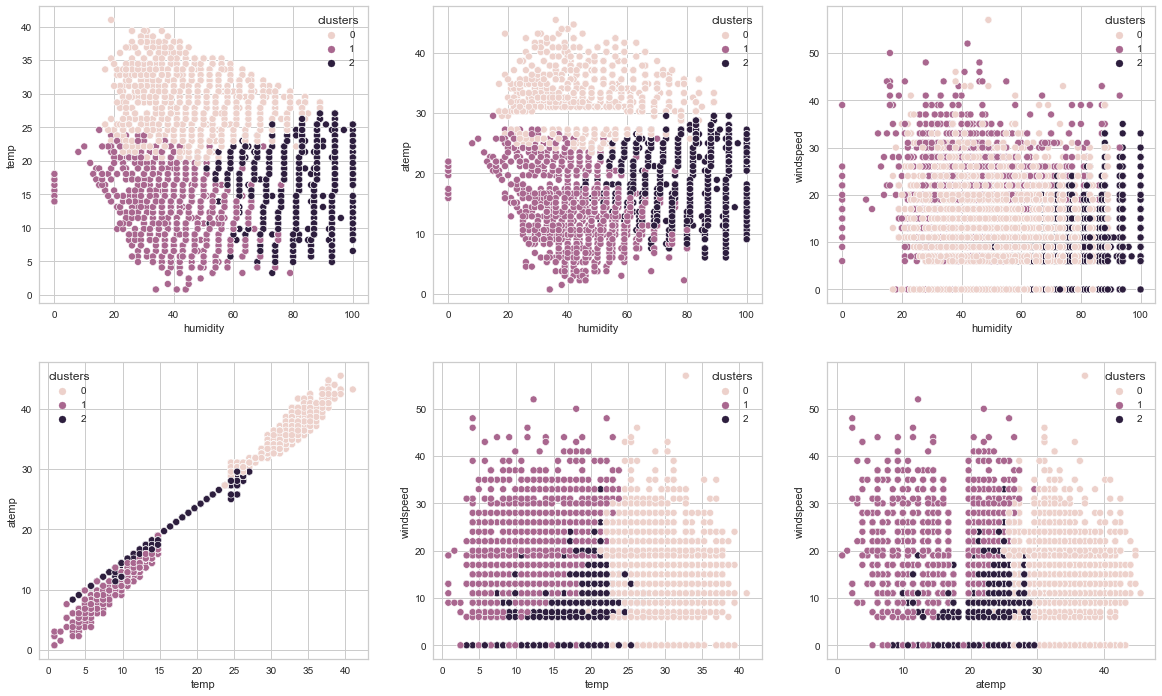

In [32]:
fig, axs = plt.subplots(2,3, figsize=(20,12))
sns.scatterplot(ax=axs[0,0], x='humidity', y='temp', data=X_train_clusters, hue='clusters')
sns.scatterplot(ax=axs[0,1], x='humidity', y='atemp', data=X_train_clusters, hue='clusters')
sns.scatterplot(ax=axs[0,2], x='humidity', y='windspeed', data=X_train_clusters, hue='clusters')
sns.scatterplot(ax=axs[1,0], x='temp', y='atemp', data=X_train_clusters, hue='clusters')
sns.scatterplot(ax=axs[1,1], x='temp', y='windspeed', data=X_train_clusters, hue='clusters')
sns.scatterplot(ax=axs[1,2], x='atemp', y='windspeed', data=X_train_clusters, hue='clusters')

On remarque que les trois clusters sont nettement caractérisés par la température et l'humidité. Le cluster 0 correspond à de basses températures (entre 0 et 15 °C) et des taux faibles à moyens en terme d'humidité (entre 0 et 60%). Le 1 à des températures moyennes (entre 15 et 27 °C avec quelques valeurs sous les 15 °C mais avec des températures ressenties relativement grandes) et de très forts taux d'humidité (entre 60 et 100 %). Et le 2 à de hautes températures (entre 25 et 42 °C) et des taux d'humidité de faibles à forts (entre 0 et 80 %). La vitesse du vent ne joue quasiment aucun rôle, sauf peut-être de dire que le cluster 2 concerne surtout des points de force de vent faible (< 20 km/h).

<AxesSubplot:xlabel='atemp', ylabel='windspeed'>

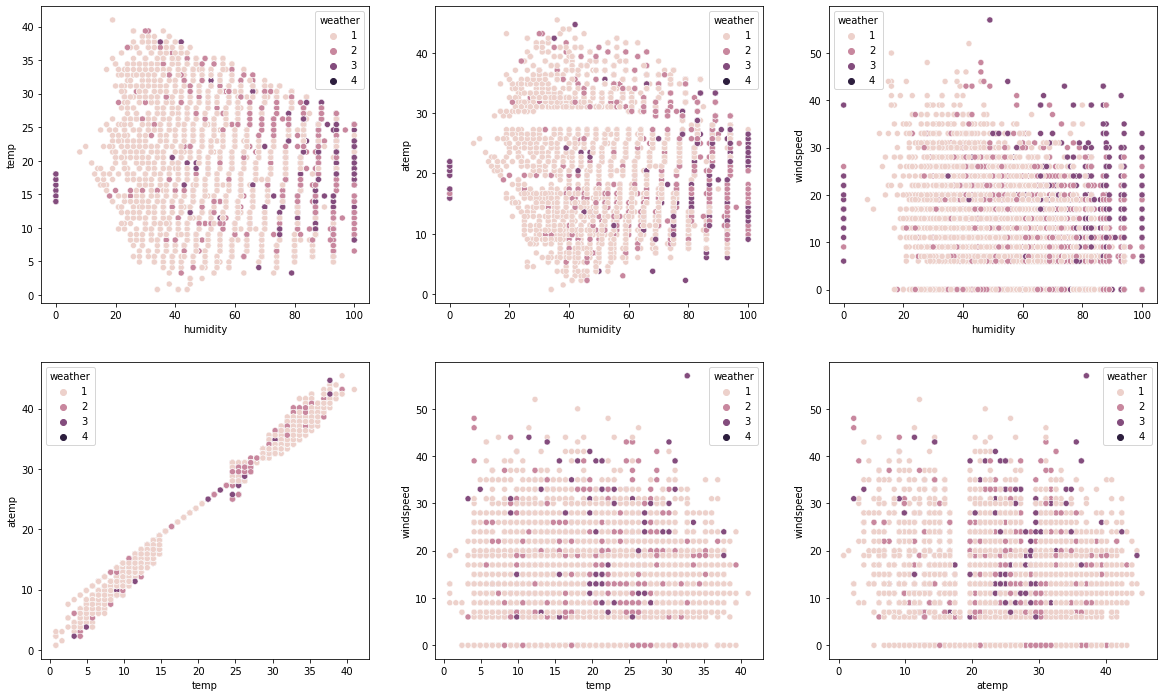

In [15]:
fig, axs = plt.subplots(2,3, figsize=(20,12))
sns.scatterplot(ax=axs[0,0], x='humidity', y='temp', data=X_train_clusters, hue='weather')
sns.scatterplot(ax=axs[0,1], x='humidity', y='atemp', data=X_train_clusters, hue='weather')
sns.scatterplot(ax=axs[0,2], x='humidity', y='windspeed', data=X_train_clusters, hue='weather')
sns.scatterplot(ax=axs[1,0], x='temp', y='atemp', data=X_train_clusters, hue='weather')
sns.scatterplot(ax=axs[1,1], x='temp', y='windspeed', data=X_train_clusters, hue='weather')
sns.scatterplot(ax=axs[1,2], x='atemp', y='windspeed', data=X_train_clusters, hue='weather')

On voit ici clairement que le temps ne correspond pas à un clustering naturel bien déterminé.

In [16]:
X_train_clusters[X_train_clusters['clusters'] == 1]

,temp,atemp,humidity,windspeed,clusters,weather
0,9.84,14.395,81,0.0000,1,1
1,9.02,13.635,80,0.0000,1,1
2,9.02,13.635,80,0.0000,1,1
3,9.84,14.395,75,0.0000,1,1
4,9.84,14.395,75,0.0000,1,1
...,...,...,...,...,...,...
8994,25.42,28.030,88,12.9980,1,1
8997,24.60,28.030,83,15.0013,1,1
8998,24.60,28.030,83,15.0013,1,1
9028,26.24,28.790,83,8.9981,1,3


In [17]:
score_silhouette = []
for n in range(2,10):
    kmeans = KMeans(n_clusters=n)
    pipeline_kmeans = make_pipeline(scaler, kmeans)
    pipeline_kmeans.fit(X)
    score_silhouette.append(silhouette_score(X, pipeline_kmeans[1].labels_, metric='euclidean'))

In [18]:
X_scaled = scaler.fit_transform(X)

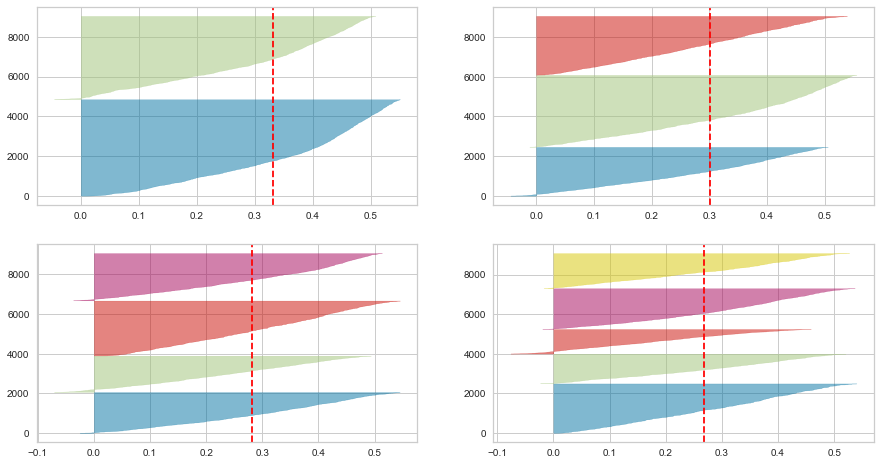

In [19]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100)
    q, mod = divmod(i, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_scaled)

In [20]:
inertias = []
mapping = {}
K = range(1, 10)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_scaled)
    
    inertias.append(kmeanModel.inertia_)
    
    mapping[k] = kmeanModel.inertia_

In [21]:
for key, val in mapping.items():
    print(f'{key} : {val}')

1 : 36156.00000000001
2 : 23037.500893657838
3 : 17686.78767639788
4 : 14396.063474668994
5 : 12695.09289931399
6 : 11425.151552467232
7 : 10282.207161141594
8 : 9451.772578517517
9 : 8717.365978123875


In [22]:
inertias_norm = [inertias[i]/max(inertias) for i in range(len(inertias))]
score_silhouette.insert(0,inertias_norm[0])

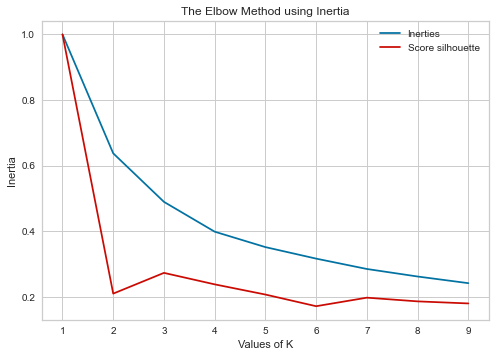

In [23]:
plt.plot(K, inertias_norm, 'bx-', label='Inerties')
plt.plot(K, score_silhouette, 'rx-', label='Score silhouette')
plt.plot
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.legend()
plt.show()

# Algorithme de classification KNN pour classer de nouvelles valeurs dans les clusters identifiés précédemment

In [36]:
knn = KNeighborsClassifier(n_neighbors=2, metric='manhattan', weights='distance')
scaler  = StandardScaler()
model = make_pipeline(scaler, knn)

model.fit(X,y)
pred_clusters = model.predict(X_test_seg)

In [58]:
pred_clusters = pd.DataFrame(pred_clusters)
pred_clusters = pred_clusters.rename(columns={0: 'clusters'})
X_test_clusters = X_test_seg.join(pred_clusters)

In [62]:
import pickle

with open('../../app/model_segmentation.pkl', 'wb') as file:
    pickle.dump(model, file)

<AxesSubplot:xlabel='atemp', ylabel='windspeed'>

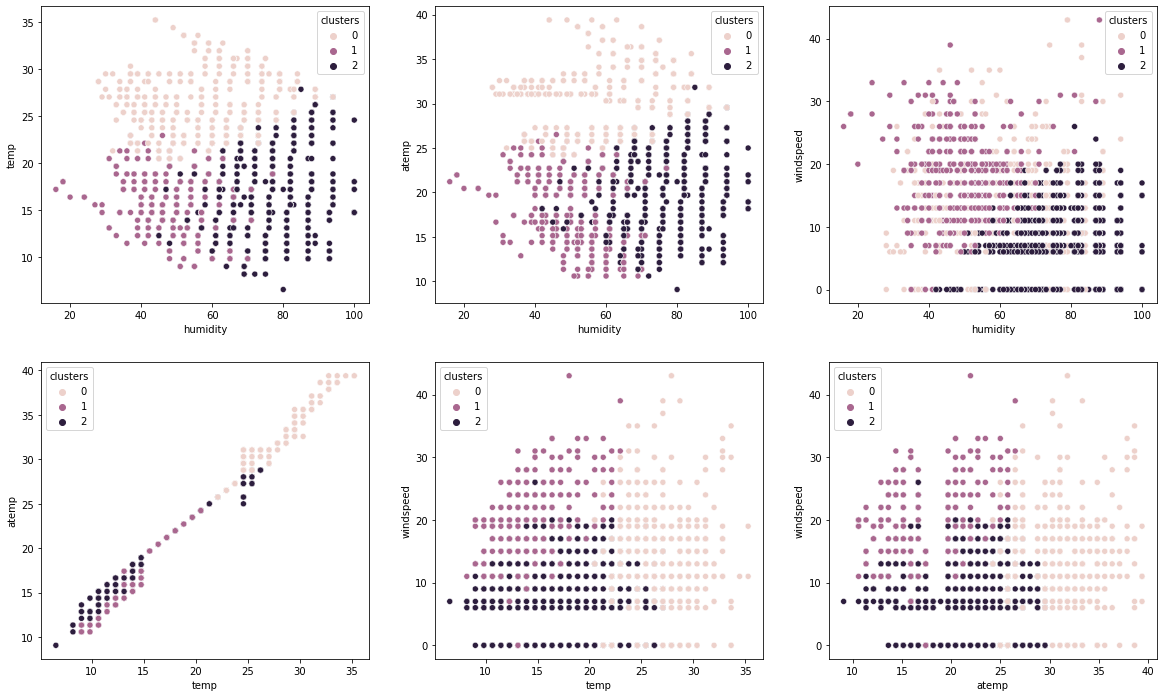

In [61]:
fig, axs = plt.subplots(2,3, figsize=(20,12))
sns.scatterplot(ax=axs[0,0], x='humidity', y='temp', data=X_test_clusters, hue='clusters')
sns.scatterplot(ax=axs[0,1], x='humidity', y='atemp', data=X_test_clusters, hue='clusters')
sns.scatterplot(ax=axs[0,2], x='humidity', y='windspeed', data=X_test_clusters, hue='clusters')
sns.scatterplot(ax=axs[1,0], x='temp', y='atemp', data=X_test_clusters, hue='clusters')
sns.scatterplot(ax=axs[1,1], x='temp', y='windspeed', data=X_test_clusters, hue='clusters')
sns.scatterplot(ax=axs[1,2], x='atemp', y='windspeed', data=X_test_clusters, hue='clusters')

In [34]:
parameters = {'kneighborsclassifier__n_neighbors': np.arange(2,10,1),
              'kneighborsclassifier__weights': ['uniform', 'distance']
              , 
              'kneighborsclassifier__metric': ['minkowski', 'euclidean', 'manhattan']}

grid = GridSearchCV(model, parameters, cv=5)
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__metric': ['minkowski',
                                                          'euclidean',
                                                          'manhattan'],
                         'kneighborsclassifier__n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']})

In [35]:
grid.best_params_

{'kneighborsclassifier__metric': 'manhattan',
 'kneighborsclassifier__n_neighbors': 2,
 'kneighborsclassifier__weights': 'distance'}